In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ComplexNets import *
from scipy.stats import unitary_group
from scipy.linalg import dft

In [3]:
def construct_model(d,L,F,reg=1e-2):
    F_tf=tf.constant(F.astype(np.complex64))
    x1m = [keras.Input(shape=(d,2,)) for i in range(L)]
    x2m= keras.Input(shape=(d,2,))

    Tim=[ComplexDense(d, use_bias=False,kernel_initializer=tf.keras.initializers.Constant(1/(d)),kernel_regularizer=RandomEnsureL2(reg/d),) for i in range(L)]
    y1=Tim[0]( complex_to_channels(channels_to_complex(x1m[0])))
    for i in range(1,L):
        y1=Tim[i]( complex_to_channels(channels_to_complex(x1m[i])*channels_to_complex(y1)))
    
    y2= channels_to_complex(x2m)*channels_to_complex(y1)

    ym=complex_to_channels(y2@F_tf)

    iout=Amplitude()(ym)**2

    model = keras.models.Model(inputs=x1m+[x2m], outputs=iout)
    return model,Tim

# Loading example simulated datasets

## Run one of the following cells

Simulation with one $80 \times 80$ - dimensional TM with an $\alpha=15$

In [4]:
data=np.load('./data/simulated_dataset_d_80_L_1_alpha_15.npy',allow_pickle=True).tolist()


Simulation with two $20 \times 20$ - dimensional TMs with an $\alpha=200$

In [14]:
data=np.load('./data/simulated_dataset_d_20_L_2_alpha_200.npy',allow_pickle=True).tolist()

Simulation with three $16 \times 16$ - dimensional TMs with an $\alpha=100000$ as shown in the paper

In [23]:
data=np.load('./data/simulated_dataset_d_16_L_3_alpha_100000.npy',allow_pickle=True).tolist()

## extracting data

In [24]:

x1ti=data['x1ti']
x2t=data['x2t']
y=data['y']
d=data['d']
L=data['L']
F=data['F']
Ti=data['Ti']
lr=data['lr']
batch_size=data['bs']
epochs=data['epochs']
reg=data['reg']


## Contruct Model

In [25]:
model,Tim=construct_model(d,L,F,reg)



# Learning

In [26]:
 tf.keras.backend.clear_session()


In [27]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr) , loss=['mse'],  metrics=['acc'])
reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.4,
                              patience=10, min_lr=lr/10,#baseline=0.9,
                              verbose=1)
history=model.fit(x1ti+[x2t], 
                  y,
                  validation_split=0.01,
                  epochs=epochs,
                  batch_size=batch_size,
                  verbose=1 ,shuffle=False,
                  callbacks = [reduce_lr],
                 )

Epoch 1/300
198/198 [==============================] - 4s 16ms/step - loss: 1.8379 - acc: 0.0627 - val_loss: 1.7980 - val_acc: 0.0591
Epoch 2/300
198/198 [==============================] - 3s 15ms/step - loss: 1.8171 - acc: 0.0631 - val_loss: 1.4170 - val_acc: 0.0637
Epoch 3/300
198/198 [==============================] - 3s 15ms/step - loss: 1.4737 - acc: 0.0623 - val_loss: 1.3689 - val_acc: 0.0642
Epoch 4/300
198/198 [==============================] - 3s 15ms/step - loss: 1.4415 - acc: 0.0623 - val_loss: 1.3569 - val_acc: 0.0629
Epoch 5/300
198/198 [==============================] - 3s 15ms/step - loss: 1.3811 - acc: 0.0627 - val_loss: 1.3521 - val_acc: 0.0611
Epoch 6/300
198/198 [==============================] - 3s 15ms/step - loss: 1.3838 - acc: 0.0627 - val_loss: 1.3499 - val_acc: 0.0616
Epoch 7/300
198/198 [==============================] - 3s 15ms/step - loss: 1.3868 - acc: 0.0628 - val_loss: 1.3484 - val_acc: 0.0622
Epoch 8/300
198/198 [==============================] - 3s 15ms

## Plotting Loss

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])



In [29]:
# Recover all TMs
Til=np.array([np.array(T.get_weights()[0]) for T in Tim])
Til= Til[:,:,:,0]+1j*Til[:,:,:,1]
Til=np.array([Til[i].T/np.linalg.norm(Til[i]) for i in range(L)])
Ti=np.array([Ti[i]/np.linalg.norm(Ti[i]) for i in range(L)])


Plotting $|T|$ and $|\widetilde{T}|$ after fixing diagonal ambiguity

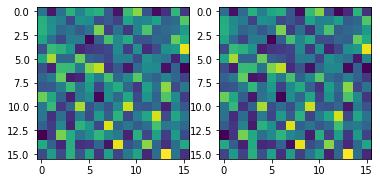

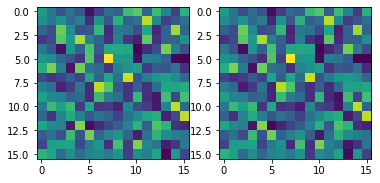

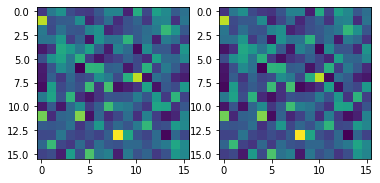

In [30]:
D=np.eye(d)
for i in range(L):
    fig,axs = plt.subplots(1,2)
    Tl=Til[i]
    To=Ti[i]
    
    #Fixing Diagonal Ambiguity in MPNN
    Tl=Tl@np.linalg.inv(D)
    D=np.diag((To/Tl)[:,1])
    Tl=D@Tl
    
    
    axs[0].imshow(np.abs(To))
    axs[1].imshow(np.abs(Tl))
    plt.show()